# Denoising Autoencoder with MNIST Digits

Import modules, upload mnist data, data normalization, apply noise

In [1]:
import random
import copy
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import os
import cv2

(x_train, _), (x_test, _) = mnist.load_data()

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step


Data normalization to values in range [0-1] and reshape to array suitable for network

In [0]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

Apply noise with noise factor 0.5

In [0]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

That is how the first 10 noisy input images looks like

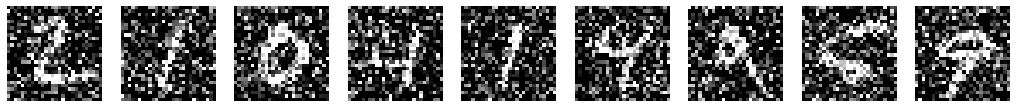

In [5]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Convolutional AutoEncoder model

In [0]:
input_img = Input(shape=(28, 28, 1))  # shape of the images that wil be on input

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Train network for 100 epochs with noisy images as input and correct images as desired output

In [7]:
log = autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
 - 10s - loss: 0.1831 - val_loss: 0.1243
Epoch 2/100
 - 7s - loss: 0.1189 - val_loss: 0.1133
Epoch 3/100
 - 7s - loss: 0.1115 - val_loss: 0.1080
Epoch 4/100
 - 7s - loss: 0.1075 - val_loss: 0.1073
Epoch 5/100
 - 7s - loss: 0.1053 - val_loss: 0.1020
Epoch 6/100
 - 7s - loss: 0.1037 - val_loss: 0.1014
Epoch 7/100
 - 7s - loss: 0.1025 - val_loss: 0.1007
Epoch 8/100
 - 7s - loss: 0.1017 - val_loss: 0.1006
Epoch 9/100
 - 7s - loss: 0.1011 - val_loss: 0.0997
Epoch 10/100
 - 7s - loss: 0.1007 - val_loss: 0.1003
Epoch 11/100
 - 7s - loss: 0.1001 - val_loss: 0.0997
Epoch 12/100
 - 7s - loss: 0.0999 - val_loss: 0.1001
Epoch 13/100
 - 7s - loss: 0.0994 - val_loss: 0.0979
Epoch 14/100
 - 7s - loss: 0.0992 - val_loss: 0.0983
Epoch 15/100
 - 7s - loss: 0.0988 - val_loss: 0.0980
Epoch 16/100
 - 7s - loss: 0.0986 - val_loss: 0.0972
Epoch 17/100
 - 7s - loss: 0.0984 - val_loss: 0.0978
Epoch 18/100
 - 7s - loss: 0.0981 - val_loss: 0.0973
Epoc

Learning loss curve

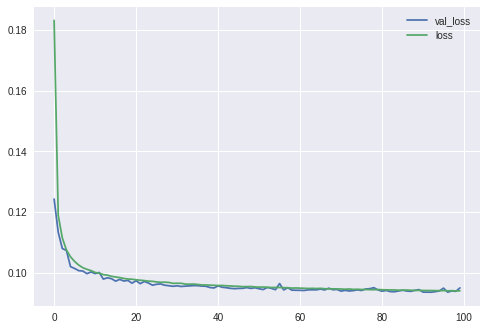

In [8]:
plt.figure()
[plt.plot(v,label=str(k)) for k,v in log.history.items()]
plt.legend()
plt.show()

Testing the denoising autoencoder and visualizing input images and output reconstruction of autoencoder

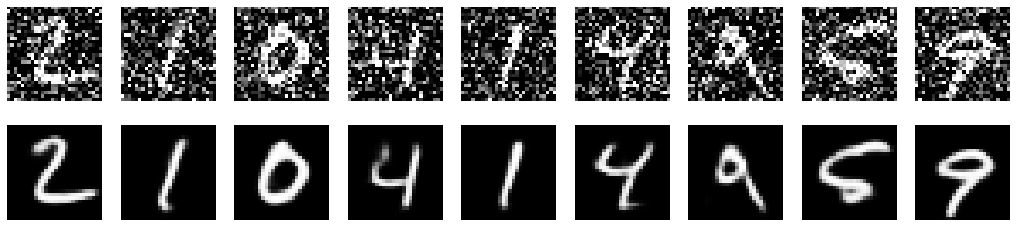

In [9]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Now, let's do the inpainting autoencoder

First we must create data for training and testing, so we apply randomly 5 stripes on images

In [0]:
stripes_no = 10
x_train_inpaint = copy.deepcopy(x_train)
x_test_inpaint = copy.deepcopy(x_test)
for i in range(len(x_train_inpaint)):
    stripes = random.sample(range(28), stripes_no)
    for j in range(len(x_train_inpaint[i])):
        if j in stripes:
            x_train_inpaint[i][j] = np.zeros((28,1))

for i in range(len(x_test_inpaint)):
    stripes = random.sample(range(28), stripes_no)
    for j in range(len(x_test_inpaint[i])):
        if j in stripes:
            x_test_inpaint[i][j] = np.zeros((28,1))

Visualizing input images with stripes

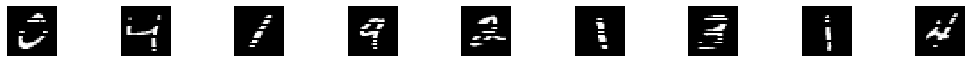

In [11]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_train_inpaint[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Fit into the same network model once again but know the images with stripes

In [12]:
log = autoencoder.fit(x_train_inpaint, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_inpaint, x_test),
                verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
 - 7s - loss: 0.0957 - val_loss: 0.0896
Epoch 2/100
 - 7s - loss: 0.0898 - val_loss: 0.0872
Epoch 3/100
 - 7s - loss: 0.0879 - val_loss: 0.0885
Epoch 4/100
 - 7s - loss: 0.0865 - val_loss: 0.0853
Epoch 5/100
 - 7s - loss: 0.0857 - val_loss: 0.0842
Epoch 6/100
 - 7s - loss: 0.0851 - val_loss: 0.0836
Epoch 7/100
 - 7s - loss: 0.0846 - val_loss: 0.0830
Epoch 8/100
 - 7s - loss: 0.0841 - val_loss: 0.0835
Epoch 9/100
 - 7s - loss: 0.0837 - val_loss: 0.0829
Epoch 10/100
 - 7s - loss: 0.0834 - val_loss: 0.0827
Epoch 11/100
 - 7s - loss: 0.0831 - val_loss: 0.0828
Epoch 12/100
 - 7s - loss: 0.0829 - val_loss: 0.0816
Epoch 13/100
 - 7s - loss: 0.0825 - val_loss: 0.0833
Epoch 14/100
 - 7s - loss: 0.0823 - val_loss: 0.0820
Epoch 15/100
 - 7s - loss: 0.0822 - val_loss: 0.0813
Epoch 16/100
 - 7s - loss: 0.0820 - val_loss: 0.0811
Epoch 17/100
 - 7s - loss: 0.0818 - val_loss: 0.0806
Epoch 18/100
 - 7s - loss: 0.0817 - val_loss: 0.0820
Epoch

Learning loss curve

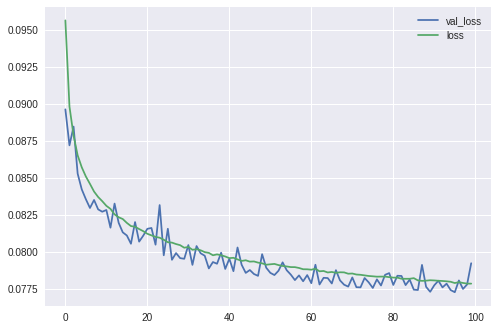

In [13]:
plt.figure()
[plt.plot(v,label=str(k)) for k,v in log.history.items()]
plt.legend()
plt.show()

Now tests and visualization of reconstructed images

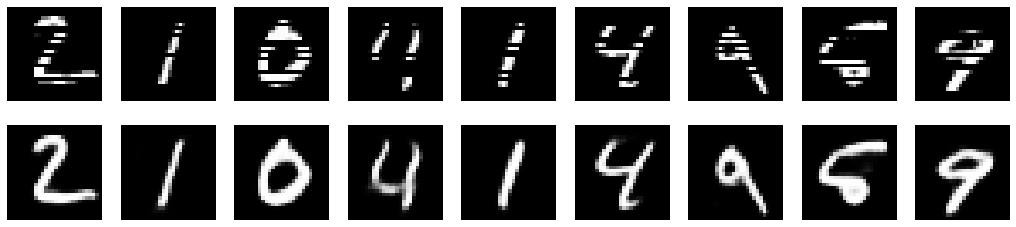

In [14]:
decoded_imgs = autoencoder.predict(x_test_inpaint)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_inpaint[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Another inpainting experiment, now with blocks

Creating data from dataset images with randomly placed gray block of size 10x10

In [0]:
block_size = 10
x_train_inpaint_block = copy.deepcopy(x_train)
x_test_inpaint_block = copy.deepcopy(x_test)
for i in range(len(x_train_inpaint_block)):
    x = random.randint(0,28-block_size)
    y = random.randint(0,28-block_size)
    for j in range(block_size):
        for k in range(block_size):
            x_train_inpaint_block[i][x+j][y+k] = 0.5 # gray color

for i in range(len(x_test_inpaint_block)):
    x = random.randint(0,28-block_size)
    y = random.randint(0,28-block_size)
    for j in range(block_size):
        for k in range(block_size):
            x_test_inpaint_block[i][x+j][y+k] = 0.5

Visualization of input images with the gray blocks

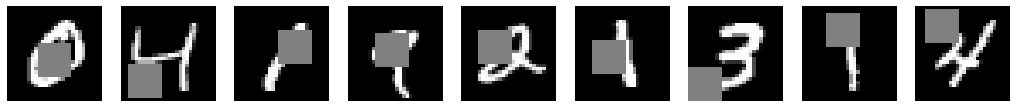

In [16]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_train_inpaint_block[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Fit into the same network model once again but know with the images with grayblocks

In [17]:
log = autoencoder.fit(x_train_inpaint_block, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_inpaint_block, x_test),
               verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
 - 7s - loss: 0.0998 - val_loss: 0.0972
Epoch 2/100
 - 7s - loss: 0.0944 - val_loss: 0.0923
Epoch 3/100
 - 7s - loss: 0.0926 - val_loss: 0.0911
Epoch 4/100
 - 7s - loss: 0.0917 - val_loss: 0.0909
Epoch 5/100
 - 7s - loss: 0.0911 - val_loss: 0.0903
Epoch 6/100
 - 7s - loss: 0.0905 - val_loss: 0.0915
Epoch 7/100
 - 7s - loss: 0.0901 - val_loss: 0.0892
Epoch 8/100
 - 7s - loss: 0.0897 - val_loss: 0.0898
Epoch 9/100
 - 7s - loss: 0.0894 - val_loss: 0.0889
Epoch 10/100
 - 7s - loss: 0.0891 - val_loss: 0.0898
Epoch 11/100
 - 7s - loss: 0.0888 - val_loss: 0.0880
Epoch 12/100
 - 7s - loss: 0.0886 - val_loss: 0.0898
Epoch 13/100
 - 7s - loss: 0.0884 - val_loss: 0.0882
Epoch 14/100
 - 7s - loss: 0.0882 - val_loss: 0.0893
Epoch 15/100
 - 7s - loss: 0.0881 - val_loss: 0.0878
Epoch 16/100
 - 7s - loss: 0.0880 - val_loss: 0.0881
Epoch 17/100
 - 7s - loss: 0.0878 - val_loss: 0.0874
Epoch 18/100
 - 7s - loss: 0.0876 - val_loss: 0.0875
Epoch

Learning loss curve

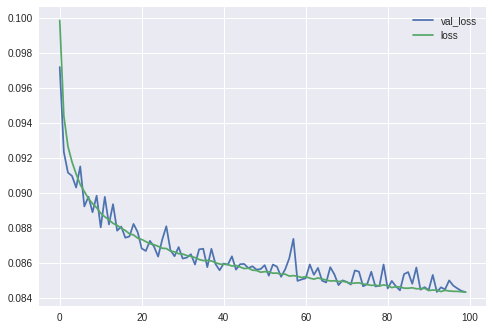

In [18]:
plt.figure()
[plt.plot(v,label=str(k)) for k,v in log.history.items()]
plt.legend()
plt.show()

Now tests and visualization of reconstructed images

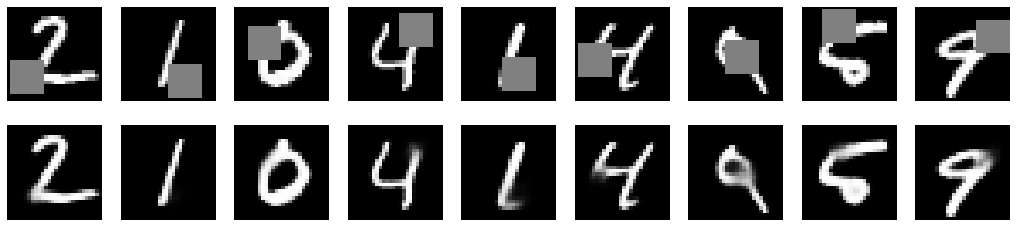

In [19]:
decoded_imgs = autoencoder.predict(x_test_inpaint_block)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_inpaint_block[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Denoising Autoencoder with image dataset

Upload the Anime images dataset and unzip

In [20]:
!wget http://www.nurs.or.jp/~nagadomi/animeface-character-dataset/data/animeface-character-dataset.zip
!unzip -qq animeface-character-dataset.zip

--2018-12-11 13:32:07--  http://www.nurs.or.jp/~nagadomi/animeface-character-dataset/data/animeface-character-dataset.zip
Resolving www.nurs.or.jp (www.nurs.or.jp)... 54.187.126.238
Connecting to www.nurs.or.jp (www.nurs.or.jp)|54.187.126.238|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 592335393 (565M) [application/zip]
Saving to: ‘animeface-character-dataset.zip.1’

animeface-character 100%[===================>] 564.89M  47.8MB/s    in 15s     

2018-12-11 13:32:22 (37.6 MB/s) - ‘animeface-character-dataset.zip.1’ saved [592335393/592335393]

replace animeface-character-dataset/index.html? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace animeface-character-dataset/README.html? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace animeface-character-dataset/README.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace animeface-character-dataset/thumb/000_hatsune_miku/color.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


Split dataset into test, validation and train data set of images, resizing images into 64x64 size

In [0]:
x_train = []
x_val = []
x_test = []

directories = os.listdir('animeface-character-dataset/thumb/')
for directory in directories:
  dir_path = 'animeface-character-dataset/thumb/'+directory
  num_fil = 0
  num_train = 0
  num_val = 0
  num_test = 0
  if os.path.isdir(dir_path):
    for filename in os.listdir(dir_path):
      if filename.endswith(".png"):
        num_fil += 1
    num_train = int(round(num_fil*0.7))
    num_val = int(round((num_fil-num_train)*0.5))
    num_test = int(round(num_fil-num_train-num_val))
    i = 0
    for filename in os.listdir(dir_path):
      if filename.endswith(".png"):
        filepath = dir_path+"/"+filename
        if i<num_train:
          img = cv2.imread(filepath, 1)
          img = cv2.resize(img, (64,64))
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          x_train.append(img)
        elif i<(num_train+num_val):
          img = cv2.imread(filepath, 1)
          img = cv2.resize(img, (64,64))
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          x_val.append(img)
        elif i<(num_train+num_val+num_train):
          img = cv2.imread(filepath, 1)
          img = cv2.resize(img, (64,64))
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          x_test.append(img)
        i += 1
x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)

This is example of images in database

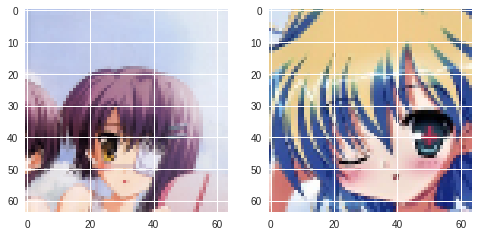

In [22]:
plt.subplot(1, 2, 1)
plt.imshow(x_train[0])
plt.subplot(1, 2, 2)
plt.imshow(x_val[10])
plt.show()

Data normalization to values in range [0-1] and reshape to array suitable for network

In [0]:
max_value = float(x_train.max())
x_train = x_train.astype('float32') / max_value
x_val = x_val.astype('float32') / max_value
x_test = x_test.astype('float32') / max_value

x_train = np.reshape(x_train, (len(x_train), 64, 64, 3))
x_val = np.reshape(x_val, (len(x_val), 64, 64, 3))
x_test = np.reshape(x_test, (len(x_test), 64, 64, 3))

Applying noise to images

In [0]:
noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_val_noisy = x_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_val.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_val_noisy = np.clip(x_val_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

That is how the first 6 noisy data images looks like

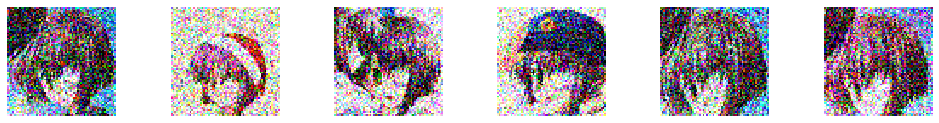

In [26]:
n = 7
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_train_noisy[i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We use similar convolutional autoencoder model as with the MNIST dataset, but now with 3 channels for RGB images

In [0]:
input_img = Input(shape=(64, 64, 3))  # shape of the images that wil be on input

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Train network for 100 epochs with noisy images as input and correct images as desired output

In [29]:
log = autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_val_noisy, x_val),
                verbose=2)

Train on 10133 samples, validate on 2184 samples
Epoch 1/100
 - 11s - loss: 0.6536 - val_loss: 0.6364
Epoch 2/100
 - 8s - loss: 0.6314 - val_loss: 0.5781
Epoch 3/100
 - 8s - loss: 0.5780 - val_loss: 0.5407
Epoch 4/100
 - 8s - loss: 0.5529 - val_loss: 0.5596
Epoch 5/100
 - 8s - loss: 0.5418 - val_loss: 0.5355
Epoch 6/100
 - 8s - loss: 0.5355 - val_loss: 0.5283
Epoch 7/100
 - 8s - loss: 0.5303 - val_loss: 0.5335
Epoch 8/100
 - 8s - loss: 0.5283 - val_loss: 0.5305
Epoch 9/100
 - 8s - loss: 0.5250 - val_loss: 0.5194
Epoch 10/100
 - 8s - loss: 0.5236 - val_loss: 0.5142
Epoch 11/100
 - 8s - loss: 0.5209 - val_loss: 0.5148
Epoch 12/100
 - 8s - loss: 0.5198 - val_loss: 0.5194
Epoch 13/100
 - 8s - loss: 0.5184 - val_loss: 0.5141
Epoch 14/100
 - 8s - loss: 0.5174 - val_loss: 0.5103
Epoch 15/100
 - 8s - loss: 0.5156 - val_loss: 0.5146
Epoch 16/100
 - 8s - loss: 0.5150 - val_loss: 0.5141
Epoch 17/100
 - 8s - loss: 0.5138 - val_loss: 0.5104
Epoch 18/100
 - 8s - loss: 0.5122 - val_loss: 0.5157
Epoch

Learning loss curve

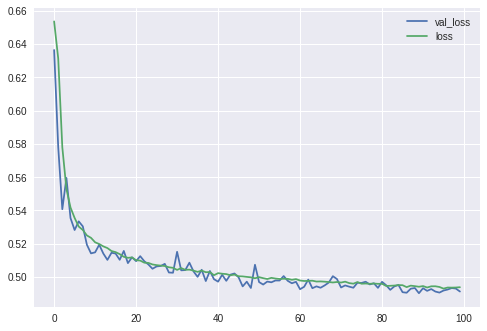

In [30]:
plt.figure()
[plt.plot(v,label=str(k)) for k,v in log.history.items()]
plt.legend()
plt.show()

Testing the denoising autoencoder and visualizing input images and output reconstruction of autoencoder

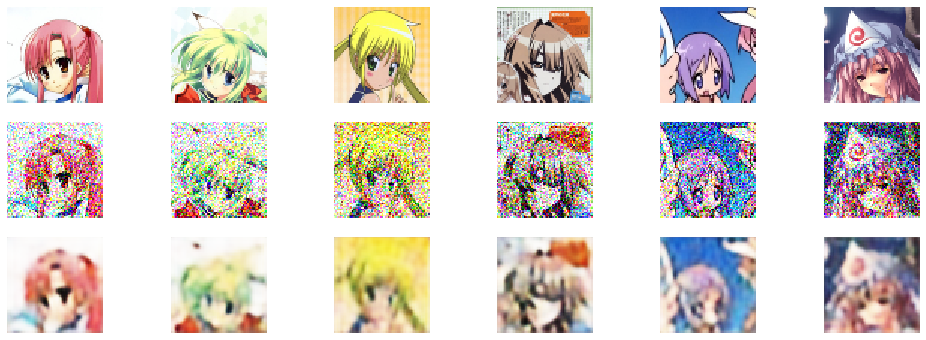

In [32]:
decoded_imgs = autoencoder.predict(x_test_noisy)
n = 7
plt.figure(figsize=(20, 6))
for i in range(1,n):
    r = random.randint(0,2173)
    # display original
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[r].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display noisy
    ax = plt.subplot(3, n, i+n)
    plt.imshow(x_test_noisy[r].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i+n + n)
    plt.imshow(decoded_imgs[r].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

plt.show()

# Inpainting images - stripes

As before, we test denoising autoencoder for inpainting, so we apply into images randomly stripes

In [0]:
stripes_no = 24
x_train_inpaint = copy.deepcopy(x_train)
x_val_inpaint = copy.deepcopy(x_val)
x_test_inpaint = copy.deepcopy(x_test)
for i in range(len(x_train_inpaint)):
    stripes = random.sample(range(64), stripes_no)
    for j in range(len(x_train_inpaint[i])):
        if j in stripes:
            x_train_inpaint[i][j] = np.zeros((64,1))
            
for i in range(len(x_val_inpaint)):
    stripes = random.sample(range(64), stripes_no)
    for j in range(len(x_val_inpaint[i])):
        if j in stripes:
            x_val_inpaint[i][j] = np.zeros((64,1))

for i in range(len(x_test_inpaint)):
    stripes = random.sample(range(64), stripes_no)
    for j in range(len(x_test_inpaint[i])):
        if j in stripes:
            x_test_inpaint[i][j] = np.zeros((64,1))

Visualizing input images with stripes

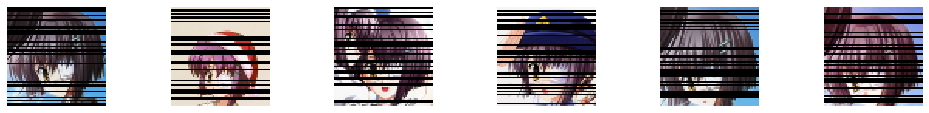

In [34]:
n = 7
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_train_inpaint[i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Fit into the same network model once again but know the images with stripes

In [36]:
log = autoencoder.fit(x_train_inpaint, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_val_inpaint, x_val),
                verbose=2)

Train on 10133 samples, validate on 2184 samples
Epoch 1/100
 - 8s - loss: 0.5398 - val_loss: 0.5187
Epoch 2/100
 - 7s - loss: 0.5197 - val_loss: 0.5164
Epoch 3/100
 - 7s - loss: 0.5137 - val_loss: 0.5100
Epoch 4/100
 - 7s - loss: 0.5096 - val_loss: 0.5049
Epoch 5/100
 - 7s - loss: 0.5070 - val_loss: 0.5057
Epoch 6/100
 - 7s - loss: 0.5058 - val_loss: 0.5031
Epoch 7/100
 - 7s - loss: 0.5039 - val_loss: 0.5075
Epoch 8/100
 - 7s - loss: 0.5034 - val_loss: 0.4999
Epoch 9/100
 - 7s - loss: 0.5026 - val_loss: 0.5022
Epoch 10/100
 - 7s - loss: 0.5012 - val_loss: 0.5046
Epoch 11/100
 - 7s - loss: 0.5010 - val_loss: 0.5024
Epoch 12/100
 - 7s - loss: 0.5000 - val_loss: 0.4985
Epoch 13/100
 - 7s - loss: 0.4995 - val_loss: 0.4966
Epoch 14/100
 - 7s - loss: 0.4989 - val_loss: 0.4985
Epoch 15/100
 - 7s - loss: 0.4985 - val_loss: 0.4960
Epoch 16/100
 - 7s - loss: 0.4984 - val_loss: 0.4964
Epoch 17/100
 - 7s - loss: 0.4976 - val_loss: 0.4970
Epoch 18/100
 - 7s - loss: 0.4973 - val_loss: 0.4957
Epoch 

Learning loss curve

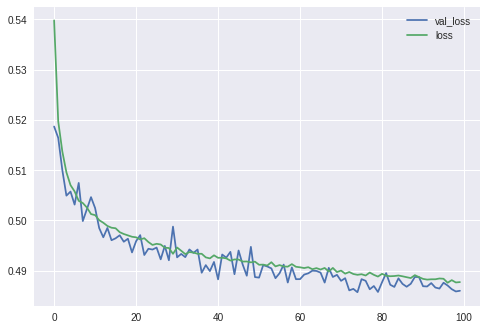

In [37]:
plt.figure()
[plt.plot(v,label=str(k)) for k,v in log.history.items()]
plt.legend()
plt.show()

Now tests and visualization of reconstructed images. Displayed in order: original image, image with stripes, reconstructed image

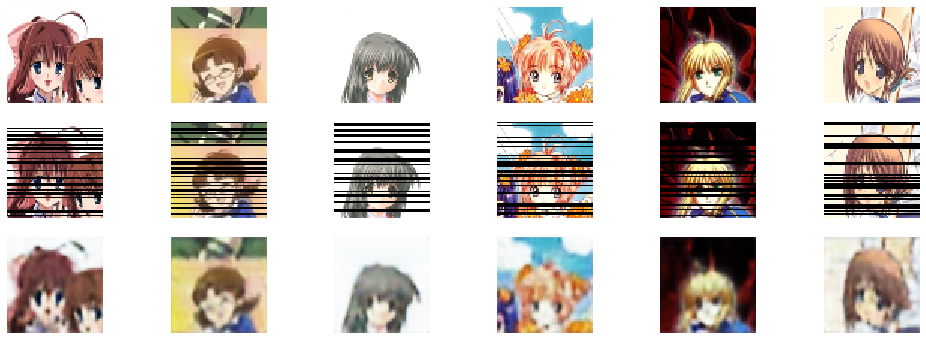

In [39]:
decoded_imgs_inpaint = autoencoder.predict(x_test_inpaint)
n = 7
plt.figure(figsize=(20, 6))
for i in range(1,n):
    r = random.randint(0,2173)
    # display original
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[r].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display noisy
    ax = plt.subplot(3, n, i+n)
    plt.imshow(x_test_inpaint[r].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i +n+ n)
    plt.imshow(decoded_imgs_inpaint[r].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

# Inpainting - blocks

Creating data from dataset images with randomly placed gray block of size 24x24

In [0]:
block_size = 24
x_train_inpaint_block = copy.deepcopy(x_train)
x_val_inpaint_block = copy.deepcopy(x_val)
x_test_inpaint_block = copy.deepcopy(x_test)
for i in range(len(x_train_inpaint_block)):
    x = random.randint(0,64-block_size)
    y = random.randint(0,64-block_size)
    for j in range(block_size):
        for k in range(block_size):
            x_train_inpaint_block[i][x+j][y+k] = 0.5 # gray color
            
for i in range(len(x_val_inpaint_block)):
    x = random.randint(0,64-block_size)
    y = random.randint(0,64-block_size)
    for j in range(block_size):
        for k in range(block_size):
            x_val_inpaint_block[i][x+j][y+k] = 0.5 

for i in range(len(x_test_inpaint_block)):
    x = random.randint(0,64-block_size)
    y = random.randint(0,64-block_size)
    for j in range(block_size):
        for k in range(block_size):
            x_test_inpaint_block[i][x+j][y+k] = 0.5

Visualizing input images with random gray blocks

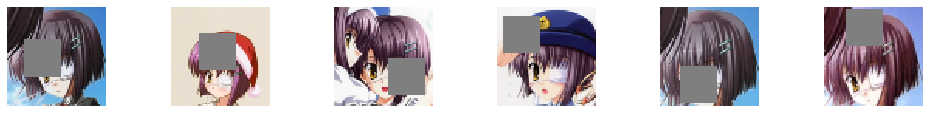

In [41]:
n = 7
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_train_inpaint_block[i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Fit into the same network model once again but know with the images with grayblocks

In [42]:
log = autoencoder.fit(x_train_inpaint_block, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_val_inpaint_block, x_val),
               verbose=2)

Train on 10133 samples, validate on 2184 samples
Epoch 1/100
 - 7s - loss: 0.5092 - val_loss: 0.5066
Epoch 2/100
 - 7s - loss: 0.5061 - val_loss: 0.5041
Epoch 3/100
 - 7s - loss: 0.5048 - val_loss: 0.5050
Epoch 4/100
 - 7s - loss: 0.5047 - val_loss: 0.5003
Epoch 5/100
 - 7s - loss: 0.5038 - val_loss: 0.5030
Epoch 6/100
 - 7s - loss: 0.5033 - val_loss: 0.5001
Epoch 7/100
 - 7s - loss: 0.5027 - val_loss: 0.5057
Epoch 8/100
 - 7s - loss: 0.5022 - val_loss: 0.5019
Epoch 9/100
 - 7s - loss: 0.5016 - val_loss: 0.5008
Epoch 10/100
 - 7s - loss: 0.5011 - val_loss: 0.4961
Epoch 11/100
 - 7s - loss: 0.5006 - val_loss: 0.4970
Epoch 12/100
 - 7s - loss: 0.5000 - val_loss: 0.4970
Epoch 13/100
 - 7s - loss: 0.4992 - val_loss: 0.4952
Epoch 14/100
 - 7s - loss: 0.4986 - val_loss: 0.5047
Epoch 15/100
 - 7s - loss: 0.4981 - val_loss: 0.4962
Epoch 16/100
 - 7s - loss: 0.4984 - val_loss: 0.4951
Epoch 17/100
 - 7s - loss: 0.4970 - val_loss: 0.4936
Epoch 18/100
 - 7s - loss: 0.4967 - val_loss: 0.4986
Epoch 

Learning loss curve

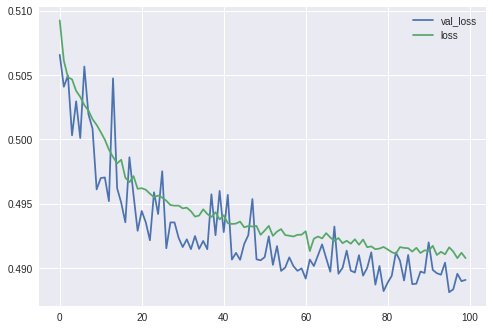

In [43]:
plt.figure()
[plt.plot(v,label=str(k)) for k,v in log.history.items()]
plt.legend()
plt.show()

Now tests and visualization of reconstructed images. Displayed in order: original image, image with gray blocks, reconstructed image

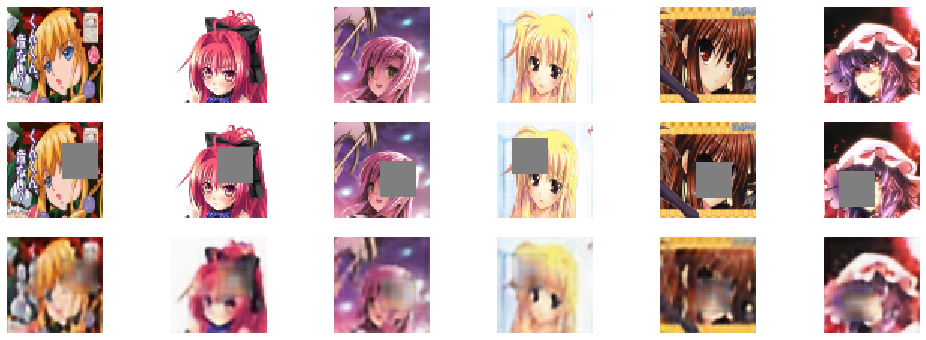

In [45]:
decoded_imgs_inpaint_block = autoencoder.predict(x_test_inpaint_block)
n = 7
plt.figure(figsize=(20, 6))
for i in range(1,n):
    r = random.randint(0,2173)
    # display original
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[r].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display noisy
    ax = plt.subplot(3, n, i+n)
    plt.imshow(x_test_inpaint_block[r].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + n + n)
    plt.imshow(decoded_imgs_inpaint_block[r].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()